**OBJECTIVE:** Prepare OSM S4 dataset for modelling with modSAR algorithm

In [1]:
import math
import numpy as np
import pandas as pd

# Import relevant modSAR classes 
from modSAR.network_algorithms import ModSAR
from modSAR.cdk_utils import CDKUtils
from modSAR.preprocessing import *
from modSAR.dataset import QSARDataset, QSARDatasetIO

from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.Geometry
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole 

import warnings
warnings.filterwarnings("ignore")

# 2.5uM in Log units
CUTOFF_ACTIVITY = - np.log10(2.5e-06)

%matplotlib inline

# Load annotated dataset

A filtered and annotated training set was compiled from raw OSM data by wvanhoorn and saved in the file **Master Chemical List - annotated.xlsx**.

An account of the steps taken to generate this file are described in [this Github issue comment](https://github.com/OpenSourceMalaria/Series4_PredictiveModel/issues/1#issuecomment-523037719) and listed below: 



    1. The columns 'PfaI EC50 uMol (Mean) Qualifier' and 'PfaI EC50 uMol (Mean)' were removed.

    2. Rows without Smiles were removed as well as rows without Pfal data. The latter means that at least oneof the remaining columns starting with 'Pfal' had to contain a value.
    
    3. The molecular structures were normalised: salts stripped, canonical tautomer calculated, charges normalised, etc.
    
    4. Rows were merged by (recalculated) InChiKey.
    
    5. Activity data was pivoted into columns 'Assay', 'Value' and 'Qualifier'. Activity values that were not IC50 like '100\% at 40 micromolar' were removed as well as values that did make sense like '0'. The original Pfal columns were left in place so that it can be seen where each data point comes from. The file was split on the three new columns so that 1 row = 1 value. During this process all other columns were copied so there is redundancy. I leave it to each individual if and how they want to average multiple values for a single compound.

    6. Series annotation was done again since not all compounds claimed to be from series 4 contained the 'triazolopyrazine core with substitutents in the northwest and northeast positions' mentioned before. When the original series annotation was '4' but the compound contains another core (or does not have two substituents in the right position) the Series annotation is overwritten as 'not4'. Note that all series are still there, leaving it open whether or not to include data from other series.

Place the file under `data/Master Chemical List - annotated.xlsx`. Create the folder `data` in the parent directory if it does not exist yet.

In [2]:
import os
if not os.path.exists('../data'):
    os.makedirs('../data')

In [3]:
X = pd.read_excel('../data/Master Chemical List - annotated.xlsx')

# Compound OSM-S-424 cannot be parsed by RDKit so we remove it from our dataset
X = X[X["OSM_ID"] != 'OSM-S-424'].copy()

# Activity data is represented by the column `Value` (in uM). Calculate pIC50 from this column:
X['pIC50'] = -np.log10(X['Value']* 1e-06)

# Save this preprocessed dataset to the ./data folder
X.to_excel('../data/osm_raw_dataset_2019_08_20.xlsx')

In [4]:
X.head(3)

,OSM_ID,Series,Assay,Value,Qualifier,PfaI EC50 (Inh),Pfal IC50 (GSK),Pfal IC50 (Syngene),Pfal IC50 (Dundee),Pfal IC50 (Avery),Pfal (K1) IC50 (Avery),Pfal IC50 (Ralph),Pfal IC50 (Guy),Pfal (K1) IC50 (Guy),Pfal IC50 (Batra),Pfal (K1) IC50 (Batra),Pfal (3D7) IC50 (Broad),Pfal (Dd2) IC50 (Broad),Canonical_Smiles,InChIKey,pIC50
0,OSM-A-1,1,Pfal IC50 (Guy),3.050,=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.050,4.379,NaN,NaN,NaN,NaN,Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4cc...,ODRSSOQWOHNABY-MOSHPQCFSA-N,5.515700
1,OSM-A-1,1,Pfal (K1) IC50 (Guy),4.379,=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.050,4.379,NaN,NaN,NaN,NaN,Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4cc...,ODRSSOQWOHNABY-MOSHPQCFSA-N,5.358625
2,OSM-A-2,1,Pfal IC50 (Guy),0.574,=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.574,1.829,NaN,NaN,NaN,NaN,Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4cc...,LXPLFPVISCVJSC-BKUYFWCQSA-N,6.241088


# Parse data with modSAR package

modSAR python package has a module `datasource.py` with a few built-in classes to automatically handle QSAR datasets:
   - ChEMBLApiDataSource: Downloads data from ChEMBL
   - ChEMBLFileDataSource: Read bioactivities that have been downloaded from ChEMBL
   - GenericFileDataSource: Read activity data from a file data source

  
For the OSM dataset, we will use the `GenericFileDataSource` to read the xlsx file we created above so it is easier to manipulate later on:

In [5]:
from modSAR.datasource import GenericFileDataSource

# Read the bioactivities in a more standard way with modSAR package

osm_dataset = GenericFileDataSource(target_id='malaria_osm4', 
                                    filepath='/mnt/data/osm_raw_dataset_2019_08_20.xlsx', 
                                    smiles_column='Canonical_Smiles', 
                                    compound_id_column='OSM_ID', 
                                    activity_column='pIC50',
                                    apply_filter=False)

In [6]:
print("Number of compounds: %d | Number of unique compounds: %d" %
      (osm_dataset.bioactivities_df.shape[0], osm_dataset.bioactivities_df['OSM_ID'].nunique()))

Number of compounds: 439 | Number of unique compounds: 347


In [7]:
# Have a look at the dataframe
osm_dataset.bioactivities_df.head(3)

,Unnamed: 0,OSM_ID,Series,Assay,Value,Qualifier,PfaI EC50 (Inh),Pfal IC50 (GSK),Pfal IC50 (Syngene),Pfal IC50 (Dundee),Pfal IC50 (Avery),Pfal (K1) IC50 (Avery),Pfal IC50 (Ralph),Pfal IC50 (Guy),Pfal (K1) IC50 (Guy),Pfal IC50 (Batra),Pfal (K1) IC50 (Batra),Pfal (3D7) IC50 (Broad),Pfal (Dd2) IC50 (Broad),Canonical_Smiles,InChIKey,pIC50
0,0,OSM-A-1,1,Pfal IC50 (Guy),3.050,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.050,4.379,NaN,NaN,NaN,NaN,Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4cc...,ODRSSOQWOHNABY-MOSHPQCFSA-N,5.515700
1,1,OSM-A-1,1,Pfal (K1) IC50 (Guy),4.379,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.050,4.379,NaN,NaN,NaN,NaN,Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4cc...,ODRSSOQWOHNABY-MOSHPQCFSA-N,5.358625
2,2,OSM-A-2,1,Pfal IC50 (Guy),0.574,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.574,1.829,NaN,NaN,NaN,NaN,Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4cc...,LXPLFPVISCVJSC-BKUYFWCQSA-N,6.241088


<AxesSubplot:>

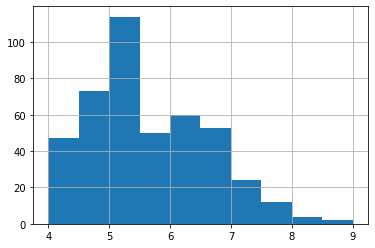

In [8]:
# Quick look into the distribution of pIC50 activity
osm_dataset.bioactivities_df['pIC50'].hist()

# Creating QSARDatasets

The modSAR package contains code to calculate molecular descriptors, which will generate a python object - a `QSARDataset` - that can be more easily manipulated than loose DataFrames or loose CSV files.

To build a dataset, we use `data_obj.build_qsar_dataset` method either one of two options:

1. `type="cdk"`: to calculate 200+ molecular descriptors with the CDK library v2 as features to the model
2. `type="morgan<n>"`: to calculate Morgan fingerprints with radius `n`. This will produce 1024 bits.


The method **build_qsar_dataset** method also performs a couple of preprocessing steps:
  1. Treats duplicated values: Duplicated compounds are discarded if standard deviation of the group is $sd(pIC_{50}) > 1$. Otherwise, the median value of activity is used. 
  2. Calculates Molecular Descriptors: Using CDK library (Java) or ECFP4 fingerprints with RDKit
  3. Returns a QSARDataset: a python object that encapsulates a full dataset

## Features = molecular descriptors with CDK

Use CDK molecular descriptors as features to the Machine Learning model.

_Uncomment the code in the following cells if you want to calculate molecular descriptors using Java CDK 2.0 library. The library is slow so it might a couple of minutes._


In [9]:
# osm4_cdk_dataset = malaria_osm4.build_qsar_dataset(type="cdk", calculate_similarity=False)

In [10]:
# osm4_cdk_dataset.y.hist()

**Save Dataset**

In [11]:
# QSARDatasetIO.write(osm4_cdk_dataset, filepath='/mnt/data/OSM-S4/osm4_qsardataset_cdk.xls')

**Load saved Dataset** 

In [12]:
# QSARDatasetIO.load(dataset_name='OSM4',
#                    activity_sheetname='activity',
#                    smiles_column='Canonical_Smiles',
#                    id_column='OSM_ID',
#                    filepath='/mnt/data/OSM-S4/osm4_qsardataset_cdk.xls',
#                    calculate_similarity=False)

## Features = Morgan fingerprints

### radius = 2 

Calculate circular Morgan fingerprints with radius=2 with RDkit to use as features to the Machine Learning model.

These fingerprints roughly correspond to the classic ECFP4 fingerprints.

In [13]:
osm_morgan2_dataset = osm_dataset.build_qsar_dataset(type="morgan2", calculate_similarity=False)

**Save Dataset**

Save it in .xlsx so it could be inspected in other softwares as well (e.g.: Excel)

In [14]:
QSARDatasetIO.write(osm_morgan2_dataset, filepath='../data/osm_qsar_dataset_morgan2.xlsx')

**Load saved Dataset** 

To load a previously saved dataset, use the `QSARDatasetIO.load` function:

In [15]:
# QSARDatasetIO.load(dataset_name='OSM4',
#                    activity_sheetname='activity',
#                    smiles_column='Canonical_Smiles',
#                    id_column='OSM_ID',
#                    filepath='/mnt/data/OSM-S4/osm4_qsardataset_ecfp4.xls',
#                    calculate_similarity=False)

### radius = 4

By increasing the radius, we let the fingerprint represent longer chains which **might** be desirable in a ML model.

In [16]:
osm_morgan4_dataset = osm_dataset.build_qsar_dataset(type="morgan4", calculate_similarity=False)

**Save Dataset**

In [17]:
QSARDatasetIO.write(osm_morgan2_dataset, filepath='../data/osm_qsar_dataset_morgan4.xlsx')

# End

That's it. This is how you generate and save features in a format that is easier to use with modSAR in the next notebooks.